In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import music21 as m21
import json
import tensorflow as tf
from tensorflow import keras

2024-09-21 11:39:33.979911: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
m21.environment.UserSettings()['musescoreDirectPNGPath']='MuseScore-Studio-4.4.2.242570931-x86_64.AppImage'

In [3]:
dataset_path = './deutschl/erk'
dataset_encoded_path = './encoded_songs/'

In [4]:
path_example_file = './deutschl/test/deut5147.krn'

In [5]:
song_example = m21.converter.parse(path_example_file)

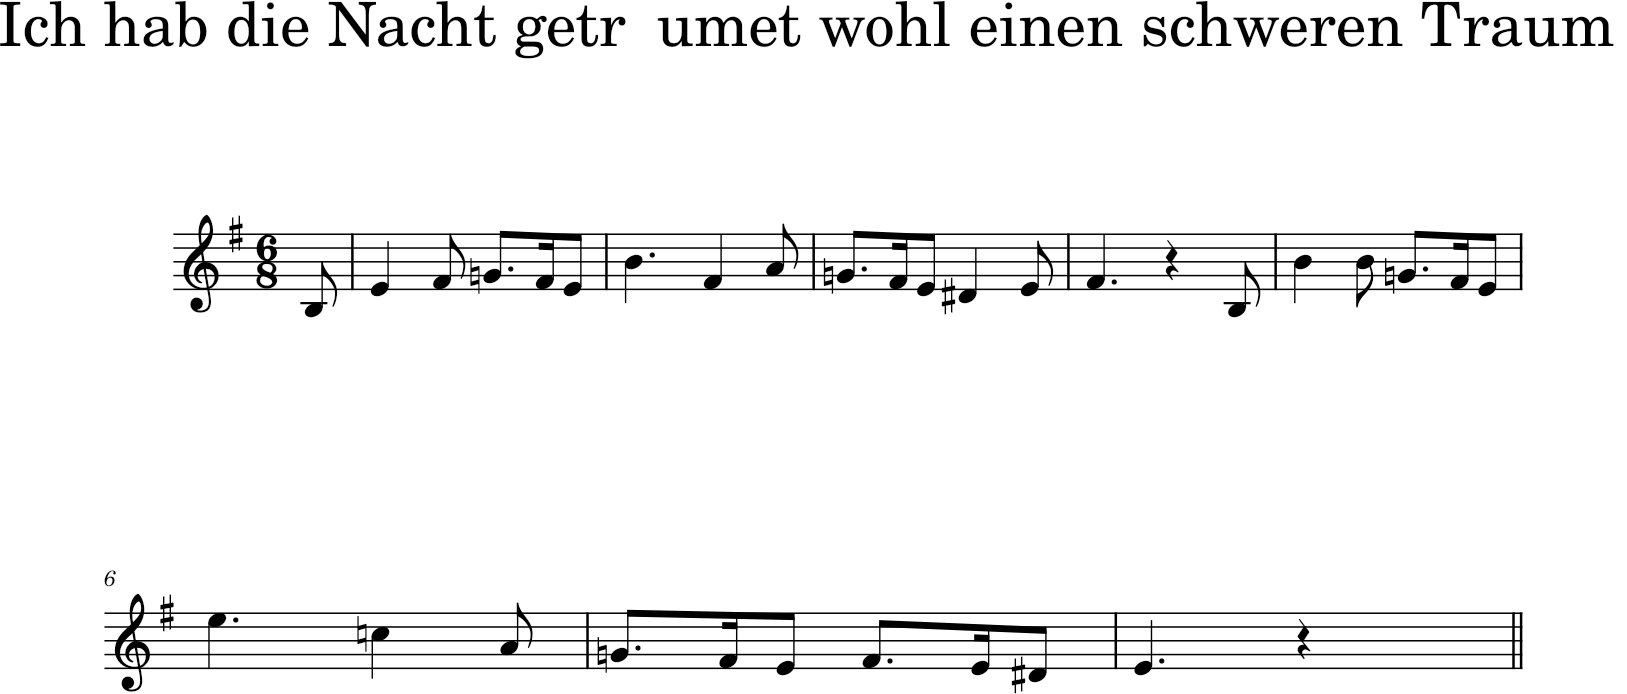

In [6]:
song_example.show()

First, we need to remove all melodies that include a note that does not have a tolerated duration, which could pose problems for the future neural network. Here, durations are expressed in quarters notes, so we choose to keep the sixteenths (0.25), the eighths (0.5), the dotted eighths (0.75), the quarters (1), the dotted quarters (1.5), the half notes (2), the dotted half notes (3) and the whole note (4). Below is a plot of the different notes and their corresponding durations. I found this picture on the website www.piano-keyboard-guide.com and added the dotted notes.

(-0.5, 931.5, 301.5, -0.5)

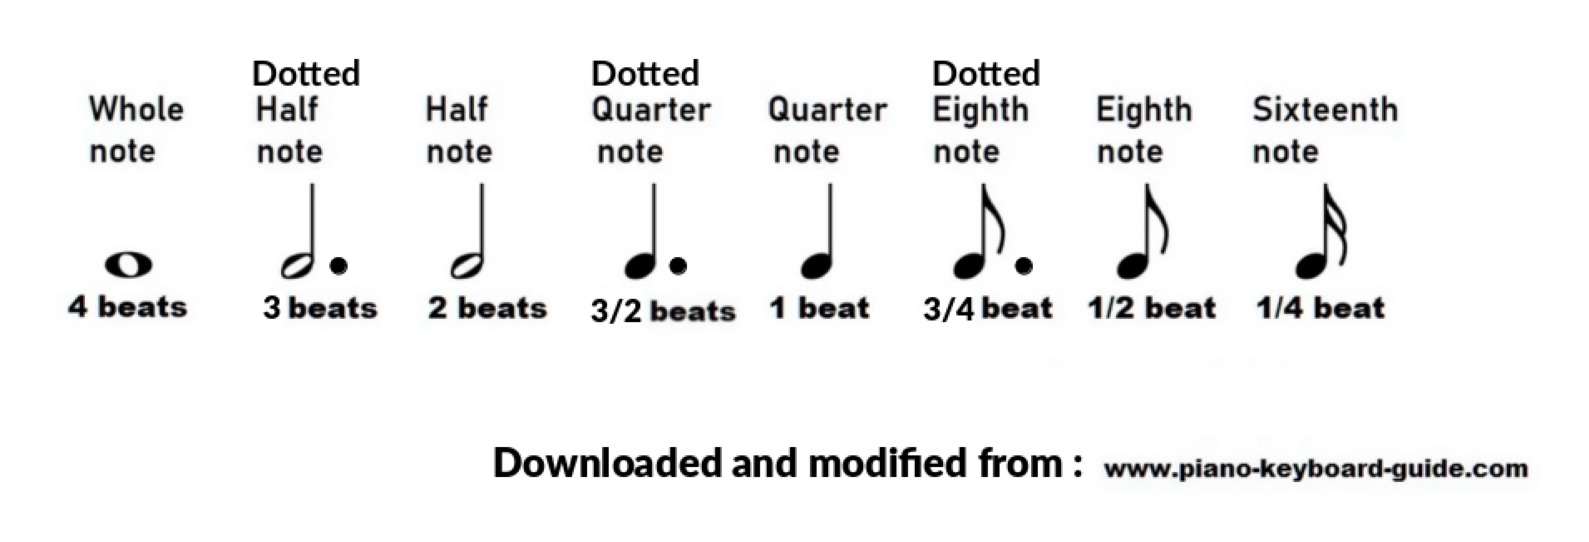

In [7]:
plt.figure(figsize=(10,15))
note_durations_img = cv2.imread('./basic_knwoledges/note_durations.png')
note_durations_img 
plt.imshow(note_durations_img)
plt.axis('off')

In [8]:
acceptable_durations = [0.25, 0.5, 0.75, 1, 1.5, 2, 3, 4]
def filter_acceptable_duration(song, acceptable_durations):
    for note in song.flatten().notesAndRests:
        if note.duration.quarterLength not in acceptable_durations:
            return False
    else:
        return True

There are a huge number of keys, so we want to avoid having too many in the learning base. This way, we'll need less data to train our model.  
That's why we transpose all the music to C sharp or A minor.  

Sometimes, the key is directly indicated at the beggining of the partition, but if it is not, we estimate it thanks to the analyze function provided in m21.

In [9]:
def transpose_key(song):
    key = (song.getElementsByClass(m21.stream.Part)[0]).getElementsByClass(m21.stream.Measure)[0][4]
    if not isinstance(key, m21.key.Key):
        key = song.analyze('key')

    if key.mode == 'major':
        interval = m21.interval.Interval(key.tonic, m21.pitch.Pitch('C'))
    elif key.mode == 'minor':
        interval = m21.interval.Interval(key.tonic, m21.pitch.Pitch('A'))

    transposed_song = song.transpose(interval)
    return transposed_song

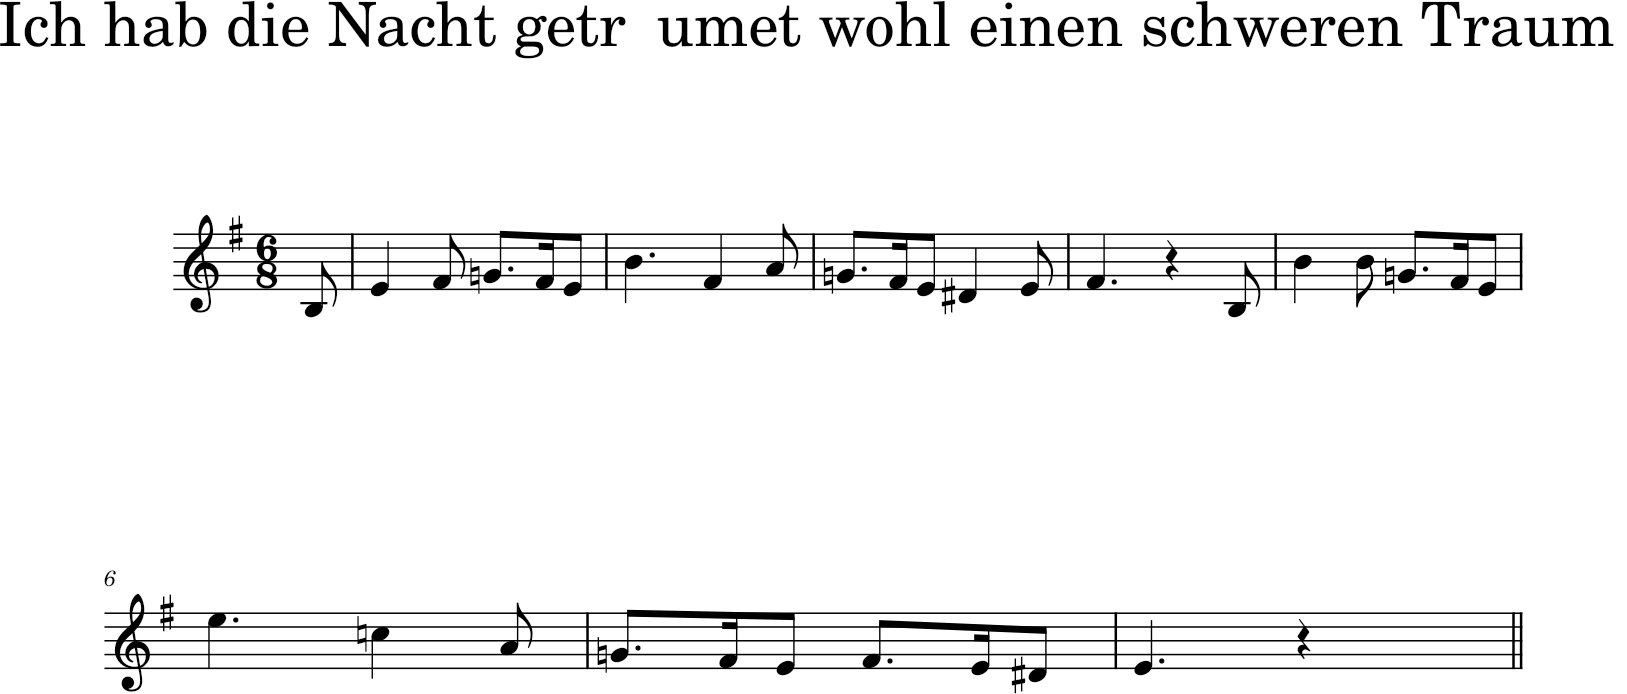

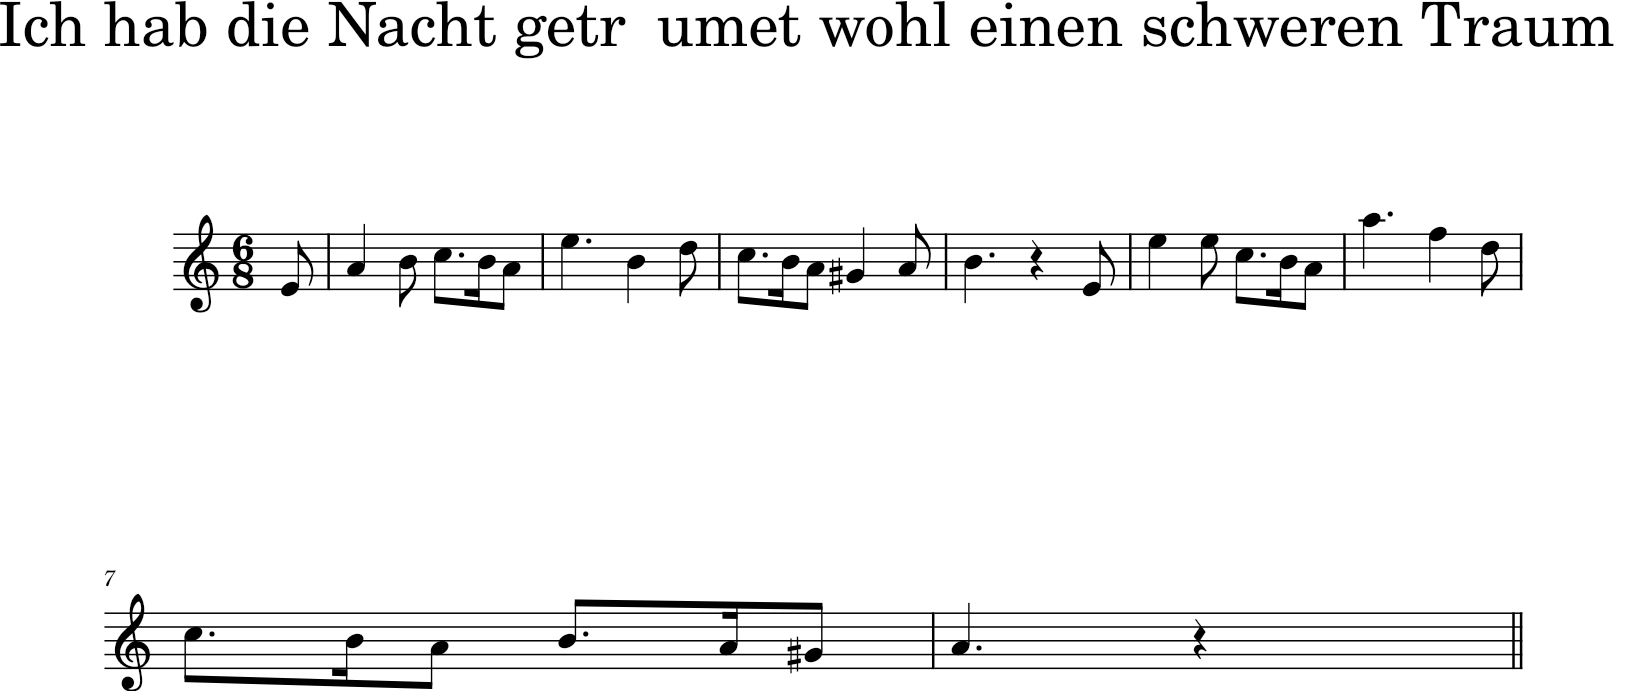

In [10]:
song_example.show()
transpose_key(song_example).show()

The final step of preprocessing is to encode song into string format.  
Each note will be encoded the following way :
- An integer (corresponding to the MIDI encoding, which translates the pitch of a note into an integer). The middle C (C4) is encoded by 60.
- The duration : each serie encode a quarter, encoded by 4 sixteenth. If a note is held during a whole quarter, we fill the serie with "_".
- A rest is encoded by a "r".

For instance, a quarter C4 is encoded \[60, '\_', '\_', '\_']

In [11]:
def encode_notes(song):
    encoded_song=[]
    time_step = 0.25
    for entity in song.flatten().notesAndRests:
        if isinstance(entity, m21.note.Note):
            symbol = str(entity.pitch.midi)
        elif isinstance(entity, m21.note.Rest):
            symbol = 'r'
        steps = int(entity.duration.quarterLength / time_step)
        for step in range(steps):
            if step==0:
                encoded_song.append(symbol)
            else:
                encoded_song.append('_')
    encoded_song_txt = ''
    for element in encoded_song:
        encoded_song_txt = encoded_song_txt + element + ' '
    return encoded_song_txt

In [12]:
def save_song_as_txt(encoded_song_txt, file_name, dataset_encoded_path):
    output_dir = dataset_encoded_path
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    file_name_txt = file_name.split('.')[-2]
    with open(output_dir + file_name_txt + '.txt', 'w') as file:
        file.write(encoded_song_txt)

In [13]:
sequence_length = 64
def write_single_files(dataset_path, dataset_encoded_path):
    for path, subdir, files in os.walk(dataset_path):
        for file in files:
            if file.split('.')[-1]=='krn':
                complete_path = os.path.join(path, file)
                subfolder = complete_path.split('/')[-2]
                song = m21.converter.parse(complete_path)
                if filter_acceptable_duration(song, acceptable_durations):
                    transposed_song = transpose_key(song)
                    encoded_song = encode_notes(transposed_song)
                    save_song_as_txt(encoded_song, file, dataset_encoded_path)
                else:
                    pass

write_single_files(dataset_path, dataset_encoded_path)

In [14]:
def concatenate_songs(dataset_encoded_path):
    whole_song_sequence = ''
    for file in os.scandir(dataset_encoded_path):
        if file.path.split('.')[-1]=='txt' and file.path.split('/')[-1]!='complete_seq.txt':
            with open(file.path, 'r') as file:
                encoded_song = file.read()
                file.close()
            whole_song_sequence = whole_song_sequence + encoded_song + '/ '* sequence_length
        with open(dataset_encoded_path + 'complete_seq.txt', 'w') as file:
            file.write(whole_song_sequence[:-1])
    return whole_song_sequence

complete_seq = concatenate_songs(dataset_encoded_path)

In [15]:
def mapping_song(whole_sequence):
    mappings = {}
    vocab = []
    seq_list = whole_sequence.split()
    for element in seq_list:
        if element not in vocab:
            vocab.append(element)
    for i, symbol in enumerate(vocab):
        mappings[symbol]=i
    with open('./encoded_songs/mapping.json', 'w') as file:
        json.dump(mappings, file, indent=4)
    return vocab, mappings

vocab, mapping = mapping_song(complete_seq)

In [16]:
def convert_sequence_to_int_serie(seq_song):
    converted_seq_to_int = []
    with open('./encoded_songs/mapping.json', 'r') as file:
        dict = json.load(file)
    for symbol in seq_song.split():
        converted_seq_to_int.append(dict[symbol])
    return converted_seq_to_int

int_serie = convert_sequence_to_int_serie(complete_seq)

In [17]:
int_serie

[0,
 1,
 2,
 1,
 1,
 0,
 3,
 1,
 0,
 1,
 2,
 1,
 1,
 2,
 2,
 1,
 4,
 1,
 5,
 1,
 1,
 4,
 5,
 1,
 2,
 1,
 6,
 1,
 7,
 1,
 0,
 1,
 8,
 1,
 9,
 1,
 1,
 10,
 5,
 1,
 9,
 1,
 4,
 1,
 1,
 8,
 2,
 1,
 4,
 1,
 5,
 1,
 1,
 5,
 9,
 1,
 5,
 1,
 5,
 1,
 2,
 1,
 2,
 1,
 8,
 1,
 9,
 1,
 1,
 10,
 5,
 1,
 9,
 1,
 4,
 1,
 1,
 8,
 2,
 1,
 4,
 1,
 5,
 1,
 1,
 5,
 9,
 1,
 5,
 1,
 5,
 1,
 2,
 1,
 2,
 1,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 2,
 4,
 8,
 1,
 1,
 1,
 4,
 1,
 1,
 1,
 12,
 1,
 1,
 1,
 10,
 1,
 1,
 1,
 8,
 1,
 1,
 1,
 8,
 1,
 9,
 1,
 4,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 4,
 1,
 1,
 1,
 4,
 1,
 1,
 1,
 8,
 1,
 1,
 1,
 4,
 1,
 1,
 1,
 4,
 1,
 1,
 1,
 5,
 1,
 1,
 1,
 5,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 5,
 1,
 4,
 1,
 1,


In [18]:
def generate_training_dataset(converted_seq, sequence_len, vocab):
    nb_of_possible_seq = len(converted_seq)-sequence_len 
    input = []
    target = []
    for k in range(nb_of_possible_seq):
        input.append(converted_seq[k:k+sequence_len])
        target.append(converted_seq[k+sequence_length])
    vocab_size = len(vocab)
    input_oh = keras.utils.to_categorical(input, num_classes=vocab_size)
    target = np.array(target)
    return input_oh, target
    

In [19]:
X, y = generate_training_dataset(int_serie, sequence_length, vocab)

In [20]:
print('Input shape : ', X.shape)
print('Target shape : ', y.shape)

Input shape :  (362178, 64, 38)
Target shape :  (362178,)


Model creation

Obviously, for this kind of task, we'll be using an RNN. More precisely, to optimize long-term memory management, we'll be using an LSTM network.

In [21]:
input = keras.layers.Input(shape=(None, X.shape[2]))
x = keras.layers.LSTM(units=128, dropout=0.2, recurrent_dropout=0.2)(input)
output = keras.layers.Dense(X.shape[2], activation = 'softmax')(x)
model = keras.Model(input, output)

2024-09-21 11:41:00.870093: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [22]:
model.compile(optimizer='adam',
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.fit(X, y, epochs=50, batch_size=32)